<a href="https://colab.research.google.com/github/gsheara/Climate-Data/blob/main/Climate_Analysis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Changes in overall climate, such as global warming, have the capacity to impact all aspects of the planet from weather patterns and storm intensity to individual ecosystems and habitats. Being able to observe, analyze, and predict the trends of the changes is crucial in addressing and preventing future damage from being done. The purpose of this notebook is to compare the average sea surface temperature of the southern and arctic oceans and forecast change in average temperature into the future.

## Data

In [ ]:
!pip install pmdarima

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import welch
from scipy.ndimage import uniform_filter1d

In [12]:
df_arctic = pd.read_csv('https://raw.githubusercontent.com/gsheara/Climate-Data/main/arctic.csv')
df_south = pd.read_csv('https://raw.githubusercontent.com/gsheara/Climate-Data/main/southern.csv')

In [46]:
df_arctic.head()

,sst,u10,hsig,time,latitude,longitude
0,271.45996,0.009604,NaN,1940-01-01 12:00:00,70.0,-140.1
1,271.45996,6.529120,NaN,1940-01-02 12:00:00,70.0,-140.1
2,271.45996,5.675279,NaN,1940-01-03 12:00:00,70.0,-140.1
3,271.45996,-10.479511,NaN,1940-01-04 12:00:00,70.0,-140.1
4,271.45996,-14.644253,NaN,1940-01-05 12:00:00,70.0,-140.1


## Analysis

A moving average of the daily sea surface temperature of each ocean is used to emphasize the overall trends in the data.

Text(0.5, 1.0, 'Arctic Ocean')

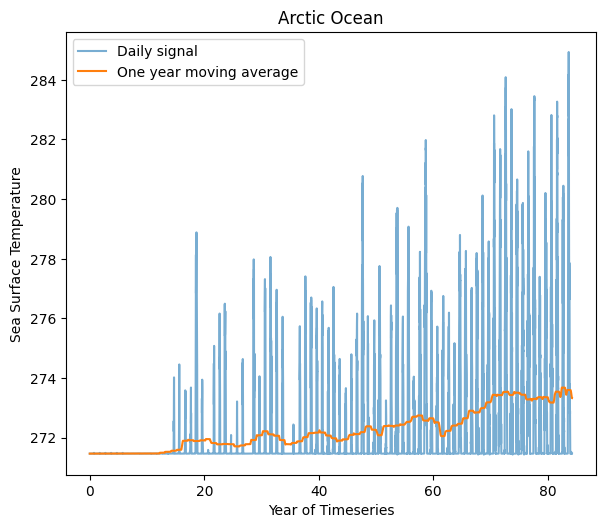

In [31]:
sst = df_arctic["sst"].values
t = np.arange(len(sst))

window_len = 365 * 5
sst_ma_arctic = uniform_filter1d(sst, size=window_len)

fig, ax = plt.subplots()
ax.plot(t / 365, sst, alpha=0.6, label="Daily signal")
ax.plot(t / 365, sst_ma_arctic, label="One year moving average")
ax.set_xlabel("Year of Timeseries")
ax.set_ylabel("Sea Surface Temperature")
ax.legend()
fig.set_size_inches(6, 5)
fig.tight_layout(pad=0.5)
plt.title('Arctic Ocean')

Text(0.5, 1.0, 'Southern Ocean')

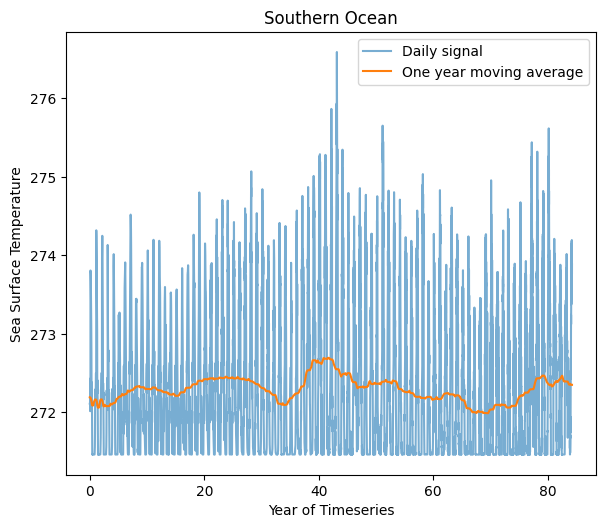

In [32]:
sst = df_south["sst"].values
t = np.arange(len(sst))

window_len = 365 * 5
sst_ma_south = uniform_filter1d(sst, size=window_len)

fig, ax = plt.subplots()
ax.plot(t / 365, sst, alpha=0.6, label="Daily signal")
ax.plot(t / 365, sst_ma_south, label="One year moving average")
ax.set_xlabel("Year of Timeseries")
ax.set_ylabel("Sea Surface Temperature")
ax.legend()
fig.set_size_inches(6, 5)
fig.tight_layout(pad=0.5)
plt.title('Southern Ocean')

Based on these two plots, it seems that there is an overall upwards trend in the arctic dataset, while some more variability in the southern dataset. The highest spike in the southern dataset seems to be in 1980, around the 40 year mark, with a gradual decline until around 2010 and then a steep incline in the years since.

Text(0.5, 1.0, 'Southern and Arctic one year moving averages')

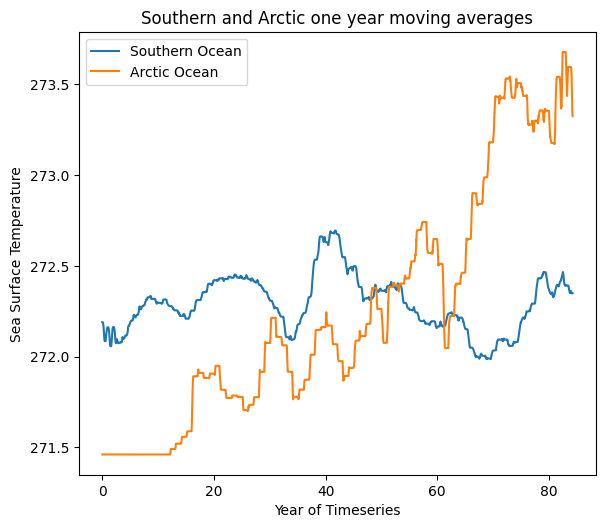

In [33]:
fig, ax = plt.subplots()
ax.plot(t / 365, sst_ma_south, label="Southern Ocean")
ax.plot(t / 365, sst_ma_arctic, label="Arctic Ocean")
ax.set_xlabel("Year of Timeseries")
ax.set_ylabel("Sea Surface Temperature")
ax.legend()
fig.set_size_inches(6, 5)
fig.tight_layout(pad=0.5)
plt.title('Southern and Arctic one year moving averages')

By plotting the two moving averages together, we can observe that the Arctic Ocean sea surface temperature moving average does increase steeply from around the year 2000 to the present, while the Southern Ocean seems to go through increases and decreases in 20 year cycles.

## Forecasting

For forecasting, I used the Prophet model because that climate patterns are imapcted over time and seasonally.

### Train/test splits

Text(0.5, 1.0, 'Arctic Average SST Training')

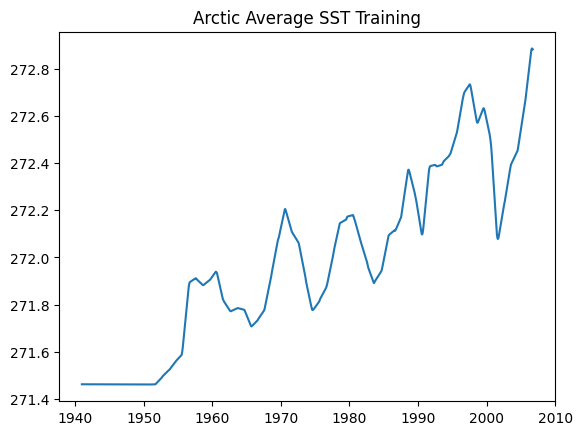

In [64]:
from prophet import Prophet

df_fit = pd.DataFrame()
df_fit["ds"] = pd.to_datetime(df_arctic["time"])
df_fit["y"] = uniform_filter1d(sst_ma_arctic, 365 * 1)
df_fit["y"] = df_fit["y"]
df_fit = df_fit.iloc[365 * 1:-365 * 1, :].reset_index(drop=True)

train_indices = list(range(8 * len(df_fit) // 10))
test_indices = list(range(8 * len(df_fit) // 10, len(df_fit)))
df_train_arctic = df_fit.loc[train_indices]
df_test_arctic = df_fit.loc[test_indices]

plt.plot(df_train_arctic["ds"], df_train_arctic["y"])
plt.title('Arctic Average SST Training')

Text(0.5, 1.0, 'Southern Average SST Training Set')

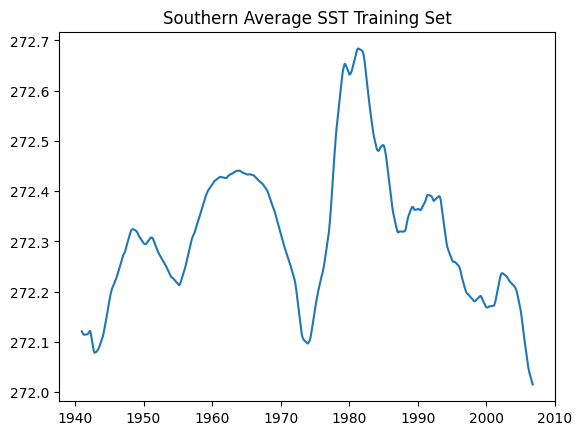

In [62]:
df_fit = pd.DataFrame()
df_fit["ds"] = pd.to_datetime(df_south["time"])
df_fit["y"] = uniform_filter1d(sst_ma_south, 365 * 1)
df_fit["y"] = df_fit["y"]
df_fit = df_fit.iloc[365 * 1:-365 * 1, :].reset_index(drop=True)

train_indices = list(range(8 * len(df_fit) // 10))
test_indices = list(range(8 * len(df_fit) // 10, len(df_fit)))
df_train_south = df_fit.loc[train_indices]
df_test_south = df_fit.loc[test_indices]

plt.plot(df_train_south["ds"], df_train_south["y"])
plt.title('Southern Average SST Training Set')

Observing these two models, it seems that they generally match the trends represented in the overall moving average plot, with arctic SST rising overtime and the southern SST displaying more variance, with a particular dip around 1975.

### Forecasts

#### Arctic

In [82]:
m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
m.fit(df_train_arctic)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk_gtt1m3/u9d2s0qc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk_gtt1m3/el_xfhf9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45282', 'data', 'file=/tmp/tmpk_gtt1m3/u9d2s0qc.json', 'init=/tmp/tmpk_gtt1m3/el_xfhf9.json', 'output', 'file=/tmp/tmpk_gtt1m3/prophet_modelcjjeftvi/prophet_model-20240522222951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:29:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:30:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [85]:
future = m.make_future_dataframe(periods=int(1.5 * len(df_test_arctic)), freq="1D")
forecast = m.predict(future)

Text(0.5, 1.0, 'Prophet Forecast of Arctic SST')

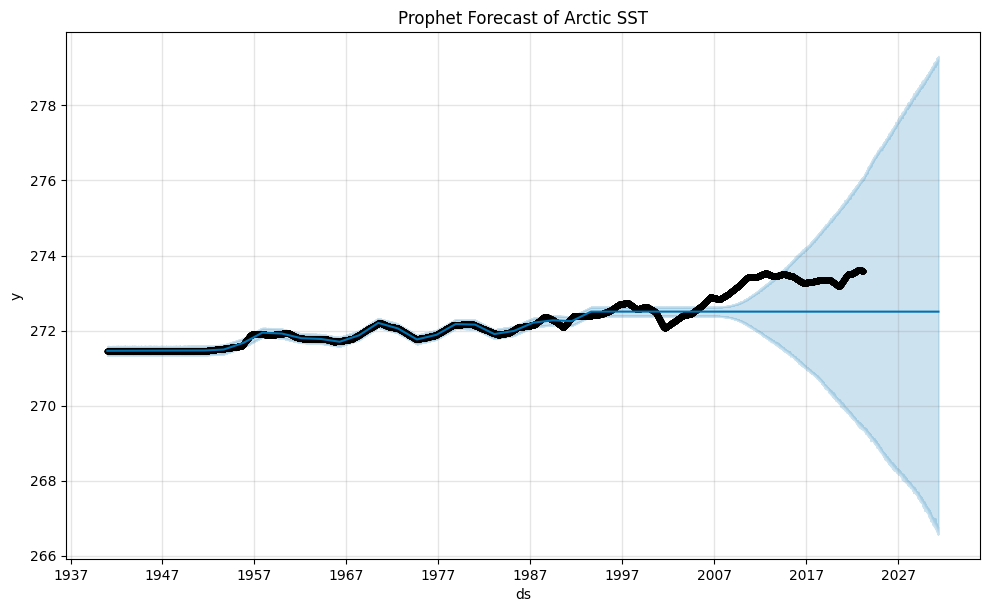

In [86]:
fig1 = m.plot(forecast)
ax = fig1.gca()
ax.plot(df_test_arctic["ds"], df_test_arctic["y"], 'ko', markersize=3)
plt.title('Prophet Forecast of Arctic SST')

In this forecast, the predicted average sea surface temperature seems to plateau, while the actual continues to increase. This difference could possibly be due to acceleration in the increase of sea surface temperature in recent years.

## Additional Analysis Step: Comparing to Southern Ocean

In [70]:
m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
m.fit(df_train_south)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk_gtt1m3/sm4iveo7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk_gtt1m3/wd83vvf1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=793', 'data', 'file=/tmp/tmpk_gtt1m3/sm4iveo7.json', 'init=/tmp/tmpk_gtt1m3/wd83vvf1.json', 'output', 'file=/tmp/tmpk_gtt1m3/prophet_modelk6h8y33b/prophet_model-20240522222335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:23:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [74]:
future = m.make_future_dataframe(periods=int(1.5 * len(df_test_south)), freq="1D")
forecast = m.predict(future)

Text(0.5, 1.0, 'Prophet Forecast of Southern SST')

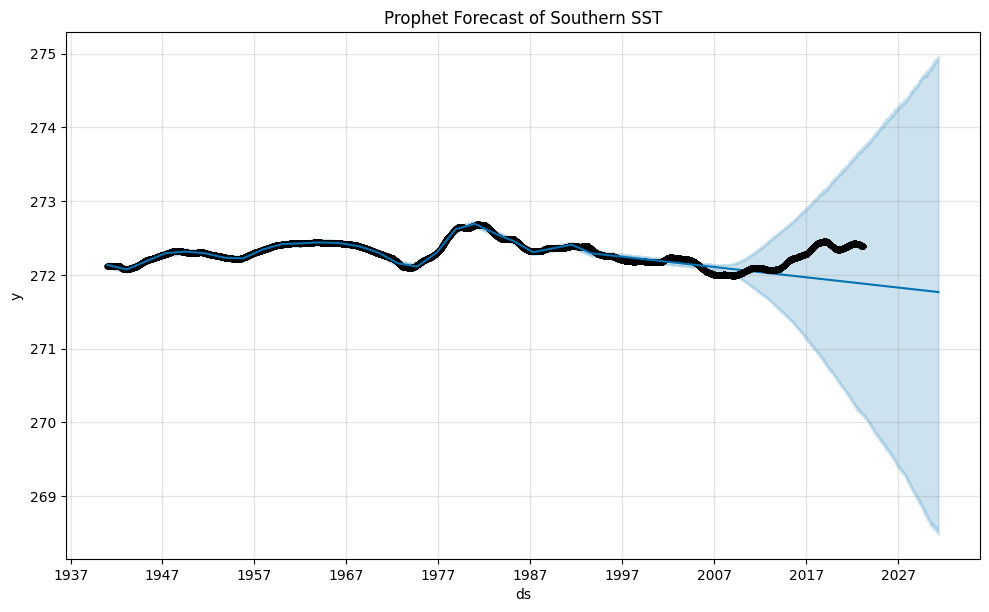

In [75]:
fig1 = m.plot(forecast)
ax = fig1.gca()
ax.plot(df_test_south["ds"], df_test_south["y"], 'ko', markersize=3)
plt.title('Prophet Forecast of Southern SST')

In this model, the sea surface temperature is predicted to decrease, as it decreases from the 1980s to 2007. However in reality, in later years from 2007-2017, it inceases again.

In both these instances, the model seems to underpredict the actual change in moving average sea surface temperature.

## Conclusion
For the sake of clarity, the analysis steps for both the arctic and southern oceans have been done alongside each other throughout this ntoebook. When compared, it seems that the southern ocean sees changes in its sea surface temperature in cycles of about 20 years, while the arctic ocean's sea surface temperature is rapidly increasing. This could possibly be due to the fact that the southern ocean, surrounding Antarctica, is larger and colder than the Arctic ocean and may be impacted by increasing sea surface temperatures and overall global warming more gradually than the Arctic.